# Lab1 - Camera Calibration

## Objectives of this Lab

1. Understand the basic principles of **camera calibration**.
2. Use images of a grid or checkerboard to calibrate a camera.
3. Correct **radial and tangential distortion errors**.
4. Visualize the effect of calibration on images.

## Lab Statement

### 1. Introduction to Camera Calibration

**Camera calibration** is the process of finding the true parameters $P$ of the camera that took your photographs.

$$x = PX$$
$$\begin{bmatrix}
X \\
Y \\
Z
\end{bmatrix} =
\begin{bmatrix}
p_1 & p_2 & p_3 & p_4 \\
p_5 & p_6 & p_7 & p_8 \\
p_9 & p_{10} & p_{11} & p_{12}
\end{bmatrix}
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}$$

Where a 3D world point $X$ is projected to a 2D image point $x$ through the camera matrix $P$.

The calibration algorithm calculates the camera matrix $P$ using the **extrinsic** and **intrinsic** parameters. The extrinsic parameters represent a rigid transformation from 3D world coordinate system to the 3D camera’s coordinate system. The intrinsic parameters represent a projective transformation from the 3D camera’s coordinates into the 2D image coordinates.

![refes](../assets/image_camera_world.png)
![calibration params](../assets/calibration_params.png)

### Camera Matrix Decomposition P
Camera projection equation:
$$P = K[R|t]$$

#### 1. Intrinsic Parameters K
$$K = \begin{bmatrix} 
f & 0 & p_x \\
0 & f & p_y \\
0 & 0 & 1
\end{bmatrix}$$

- $f$: Focal length in pixels
- $(p_x, p_y)$: Principal point (usually near image center)

#### 2. Extrinsic Parameters [R|t]
Rotation matrix:
$$R = \begin{bmatrix}
r_1 & r_2 & r_3 \\
r_4 & r_5 & r_6 \\
r_7 & r_8 & r_9
\end{bmatrix}$$

Translation vector:
$$t = \begin{bmatrix}
t_1 \\
t_2 \\
t_3
\end{bmatrix}$$

- Together [R|t] defines camera pose in world coordinates

#### 3. Complete Projection Matrix
$$P = \begin{bmatrix} 
f & 0 & p_x \\
0 & f & p_y \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_1 & r_2 & r_3 & t_1 \\
r_4 & r_5 & r_6 & t_2 \\
r_7 & r_8 & r_9 & t_3
\end{bmatrix}$$


#### a. What are the **intrinsic parameters** of a camera?

Intrinsic parameters define the internal characteristics of a camera that impact image capture. These include:

- **Focal Length (f):** Determines the distance from the lens to the image sensor and affects the scale of the captured image.
- **Principal Point (px, py) or optical center (cx, cy):** The point on the image sensor where the optical axis intersects, usually near the image center.
- **Skew Coefficient:** Accounts for any non-orthogonality between the x and y axes of the image sensor, though often assumed to be zero in modern cameras.
- **Lens Distortion Coefficients:** Describe how the lens distorts straight lines in the image, affecting the geometric accuracy.

#### b. What are the **extrinsic parameters** of a camera?

Extrinsic parameters define the camera's position and orientation in the 3D world relative to a coordinate system. These include:

- **Translation Vector (T):** Indicates the camera's position in 3D space.
- **Rotation Matrix (R):** Represents the orientation of the camera relative to world coordinates, defining rotation around the x, y, and z axes.

#### c. What are the main distortions that affect a camera (radial, tangential)?

The main distortions that impact camera images include:

- **Radial Distortion:** Occurs when light rays passing through the lens bend differently based on their distance from the optical center, causing straight lines to appear curved in the image. Common types include:
  - **Barrel Distortion:** Lines bow outward.
  - **Pincushion Distortion:** Lines bow inward.

![radial distortion](../assets/radial_distortion.png)

- **Tangential Distortion:** Happens when the lens is misaligned with the image sensor, displacing the image in a tangential direction and creating a skewed perspective.
  ![tangentiel distortion](../assets/tangentiel_ditrotion.png)

### 2. Loading and Preparing Images
for the images dataset i use [`the Chessboard Pictures for Stereocamera Calibration`](https://www.kaggle.com/datasets/danielwe14/stereocamera-chessboard-pictures).

#### About Dataset
Within this Dataset you find **40 pictures** of the same checkerboard pattern, produced with two equal cameras. (so you have 20 pictures per camera). The Data is divided into two folders **leftcamera** for the left camera and **rightcamera** for the right one. The images are numbered. Image 1 of the left camera (`Im_L_1.png`) therefore belongs to image 1 of the right camera (`Im_R_1.png`). They show the same scenario from different points of view.

To get started you have to know a fiew things about the given data. The square size of the checkerboard is ``30mm``. The board size is ``11x7`` (counted by the corners of the squares).

below we used to download and extarcte the dataset content to the ``dataset`` dir using the new kagglehub library.

![exmaple image](../assets/Im_L_1.png)

In [10]:
import kagglehub
import os
import shutil

# Download the dataset to the default location
path = kagglehub.dataset_download("danielwe14/stereocamera-chessboard-pictures", force_download=True)

current_path = os.getcwd()

# Define the destination path
destination_path = os.path.join(current_path, "dataset")

# Check if the destination path exists and has content
if os.path.exists(destination_path) and os.listdir(destination_path):
    # Remove the existing directory and its contents
    shutil.rmtree(destination_path)

shutil.move(path, destination_path)

print("Path to dataset files:", destination_path)

100%|██████████| 14.8M/14.8M [00:10<00:00, 1.54MB/s]

Extracting files...


Path to dataset files: f:\Hamza_OK\Computer_Vision_labs\Lab1\dataset


### 3. Detecting Checkerboard Corners

To detect checkerboard corners in images using **OpenCV**, i use the ``cv2.findChessboardCorners`` function. 

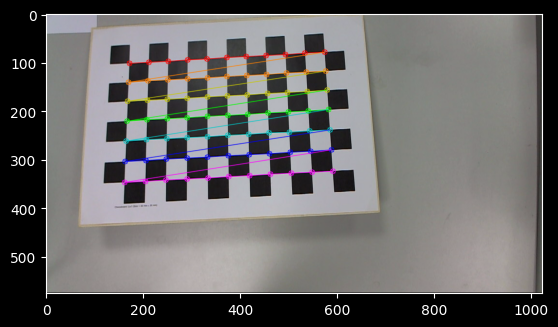

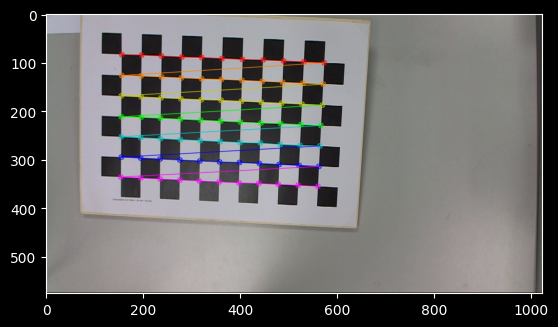

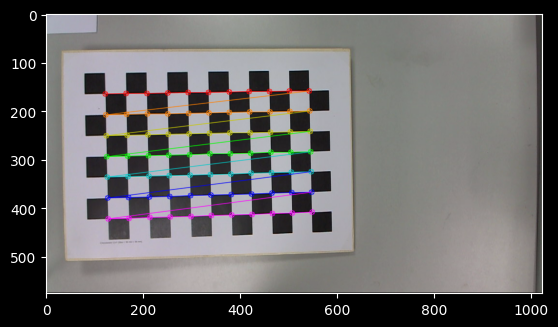

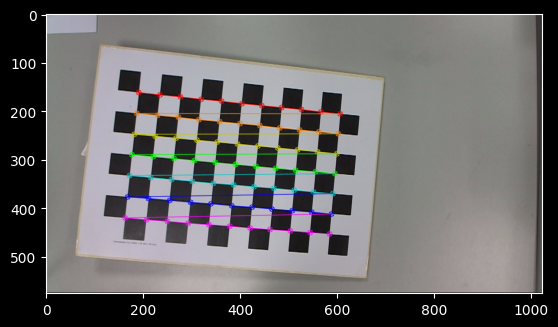

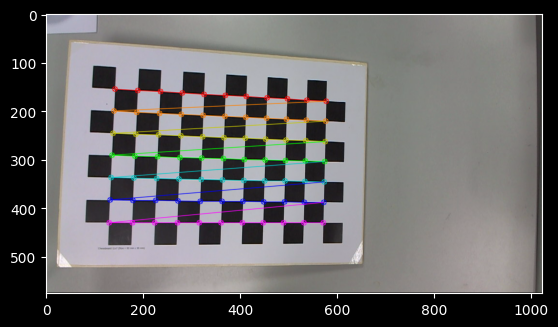

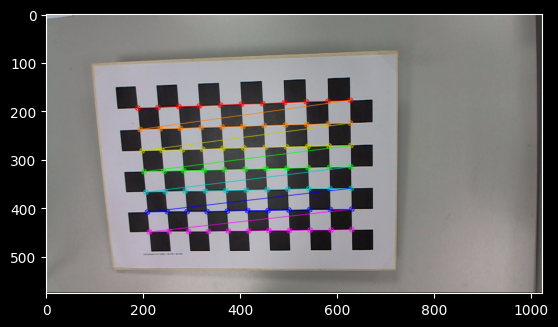

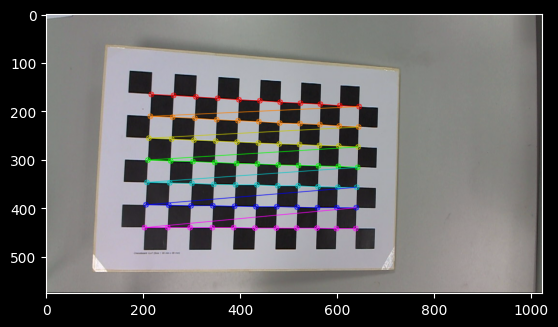

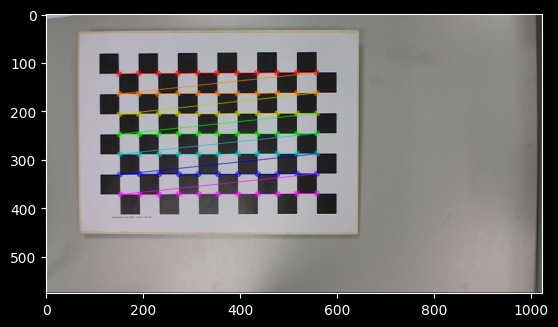

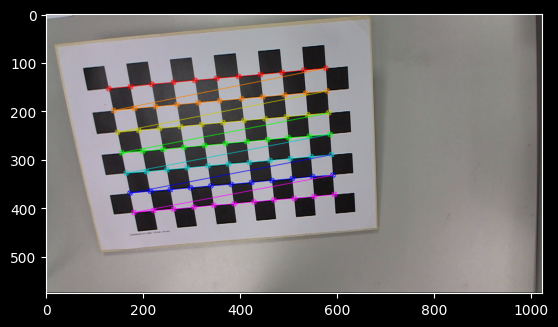

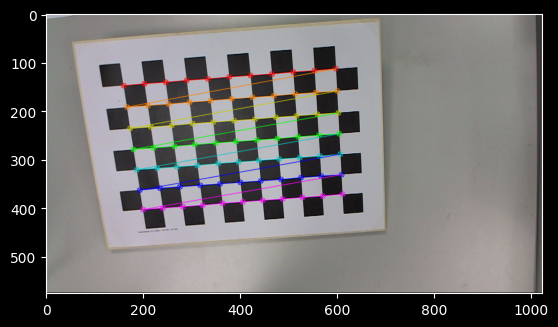

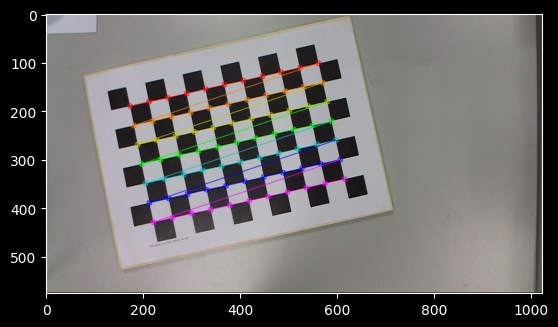

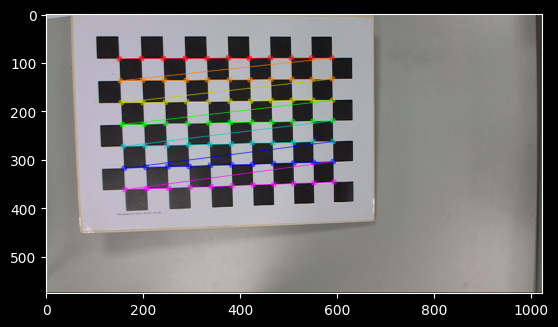

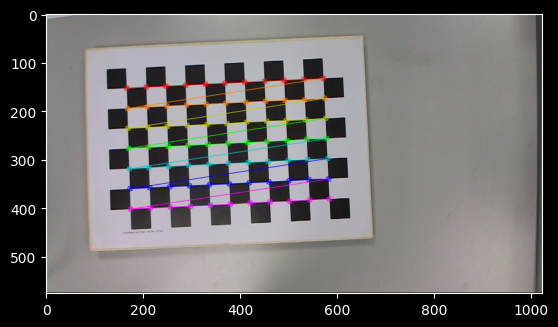

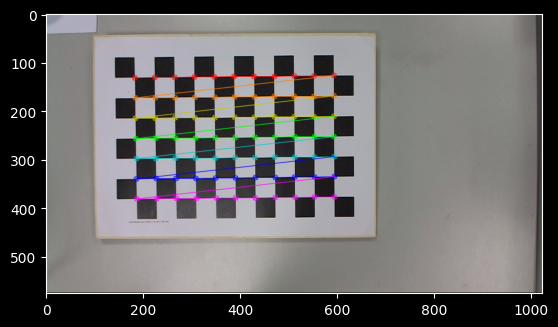

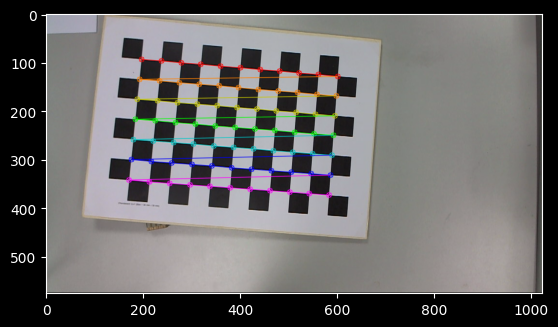

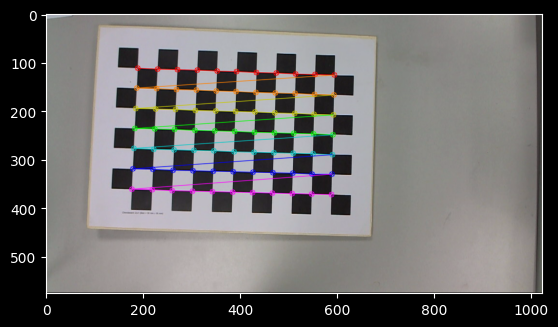

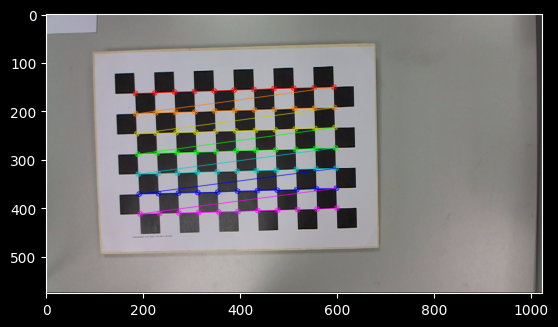

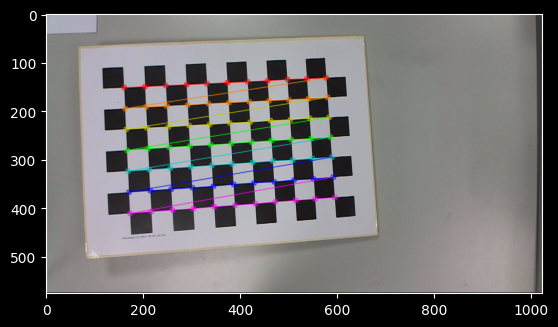

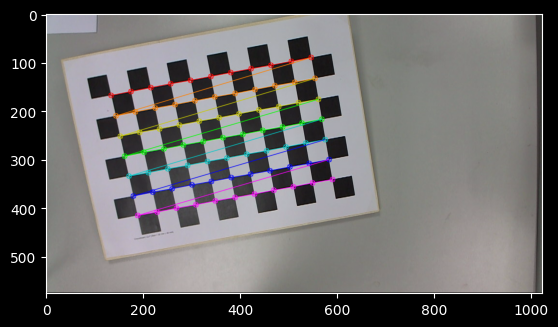

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

SQUARE_SIZE = 30  # how big are the squares of the checkerboard pattern (in millimeters)
BOARD_SIZE = (11,7)  # size of the chessboard (measured from the crossing corners of the squares)

# Prepare object points (3D) based on the checkerboard dimensions
objp = []
for i in range(BOARD_SIZE[1]):
    for j in range(BOARD_SIZE[0]):
        objp.append([j * SQUARE_SIZE, i * SQUARE_SIZE, 0])
objp = np.array(objp, dtype=np.float32)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real-world space
imgpoints = []  # 2d points in image plane

images = glob.glob("dataset/data/imgs/leftcamera/*.png")

for image_file in images:
    # Load image and convert to grayscale
    image = cv2.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the checkerboard corners
    ret, corners = cv2.findChessboardCorners(gray, BOARD_SIZE, None)

    # If found, add object points, image points (after refining them)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        corners_refined = cv2.cornerSubPix(
            gray,
            corners,
            (11, 11),
            (-1, -1),
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001),
        )

        cv2.drawChessboardCorners(image, BOARD_SIZE, corners_refined, ret)

        # Display the image with detected corners
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()


### 4. Camera Calibration

After detecting the checkerboard corners, i can perform camera calibration using ``cv2.calibrateCamera`` to obtain the **camera matrix** (represents the **intrinsic parameters**) and **distortion coefficients**. With these parameters, i can then undistort the images to remove any lens distortion.

In [7]:
ret, camera_matrix, distortion_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Calibration results: ", ret)
print("\nCamera matrix:\n", camera_matrix)
print("\nDistortion coefficients:\n", distortion_coeffs)
print("\nRotation vectors:\n", rvecs)
print("\nTranslation vectors:\n", tvecs)

Calibration results:  0.1859833166336822

Camera matrix:
 [[717.66258693   0.         523.57147487]
 [  0.         728.70920499 285.29822825]
 [  0.           0.           1.        ]]

Distortion coefficients:
 [[ 3.01349748e-02 -1.75504950e-01  7.80993819e-04  1.09032150e-04
   2.05540618e-01]]

Rotation vectors:
 (array([[-0.18420715],
       [ 0.00425931],
       [-0.05410813]]), array([[0.08429741],
       [0.01444254],
       [0.04557799]]), array([[ 0.00212428],
       [-0.05537748],
       [-0.02293909]]), array([[-0.03560655],
       [-0.08026067],
       [ 0.09353973]]), array([[-0.03347232],
       [-0.1615451 ],
       [ 0.03003122]]), array([[ 0.13849672],
       [ 0.06865688],
       [-0.02997124]]), array([[-0.03408782],
       [-0.15525882],
       [ 0.03531422]]), array([[ 0.0197663 ],
       [ 0.00545239],
       [-0.0034809 ]]), array([[ 0.23091462],
       [-0.00464977],
       [-0.08840663]]), array([[ 0.18073036],
       [-0.00162394],
       [-0.07459506]]), arra

### 5. Distortion Correction

With the calibration data, we create a new camera matrix with ``cv2.getOptimalNewCameraMatrix`` and then undistort the image using ``cv2.undistort``. This function corrects the distortion based on the camera parameters, producing a "flattened" view.

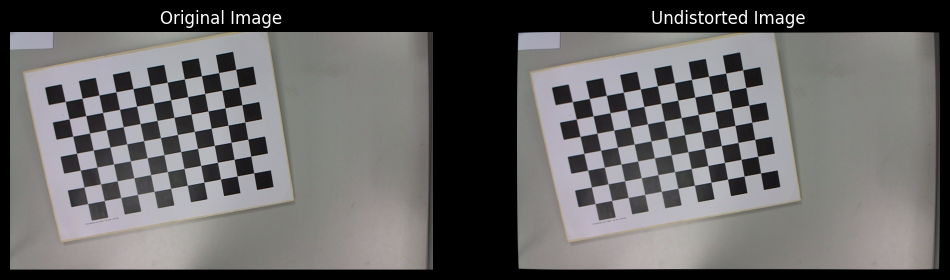

In [10]:
# Undistort and display an example image
example_image = cv2.imread(images[18])
h, w = example_image.shape[:2]
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, distortion_coeffs, (w, h), 1, (w, h))

# Undistort the image
undistorted_image = cv2.undistort(example_image, camera_matrix, distortion_coeffs, None, new_camera_matrix)

# Display original and undistorted images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
axs[1].set_title("Undistorted Image")
axs[1].axis('off')
plt.show()

# x, y, w, h = roi
# undistorted_image = undistorted_image[y:y+h, x:x+w]
# cv2.imwrite('calibrated_result.jpg', undistorted_image)

### 7. Calibration Evaluation

To evaluate the calibration, i use the **Mean Re-projection Error** method, it measures the difference between the 3D points (**objpoints**) projected onto the 2D image plane and comparing them to the actual detected corners. Ideally, this error should be small.

In [11]:
# Calculate re-projection error
total_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], camera_matrix, distortion_coeffs)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    total_error += error

mean_error = total_error / len(objpoints)
print("Mean re-projection error: {:.4f}".format(mean_error))


Mean re-projection error: 0.0210


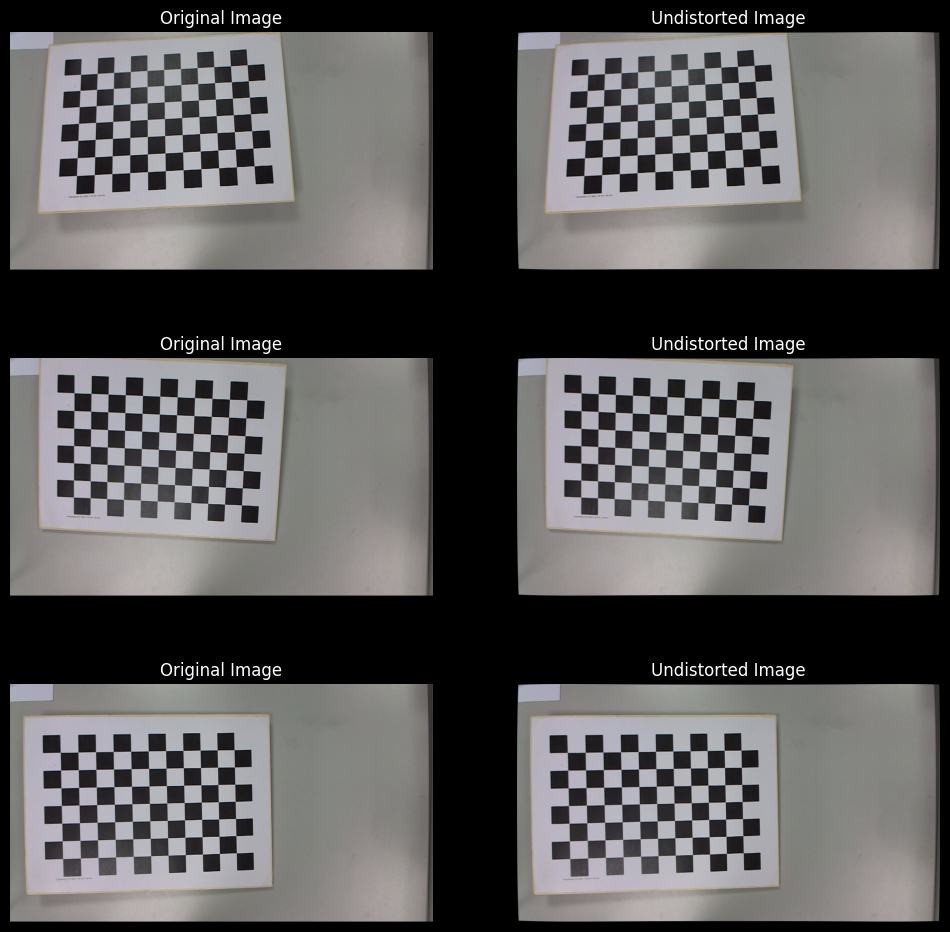

Mean Reprojection Error: 0.020986181806732944


In [12]:
# Display several images before and after undistortion
num_images_to_display = 3 # number of images to display
fig, axs = plt.subplots(num_images_to_display, 2, figsize=(12, 4 * num_images_to_display))

for i, image_file in enumerate(images[:num_images_to_display]):

    original_image = cv2.imread(image_file)
    undistorted_image = cv2.undistort(original_image, camera_matrix, distortion_coeffs, None, new_camera_matrix)

    # Display original image
    axs[i, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    # Display undistorted image
    axs[i, 1].imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
    axs[i, 1].set_title("Undistorted Image")
    axs[i, 1].axis("off")

plt.show()

print(f"Mean Reprojection Error: {mean_error}")


Point projection equation:
$$x = PX$$

Homogeneous coordinate transformation:
$$\begin{bmatrix}
X \\
Y \\
Z
\end{bmatrix} =
\begin{bmatrix}
p_1 & p_2 & p_3 & p_4 \\
p_5 & p_6 & p_7 & p_8 \\
p_9 & p_{10} & p_{11} & p_{12}
\end{bmatrix}
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}$$

Camera projection equation:
$$P = K[R|t]$$

Complete projection matrix:
$$P = \begin{bmatrix} 
f & 0 & p_x \\
0 & f & p_y \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_1 & r_2 & r_3 & t_1 \\
r_4 & r_5 & r_6 & t_2 \\
r_7 & r_8 & r_9 & t_3
\end{bmatrix}$$

Rotation and translation matrices:
$$R = \begin{bmatrix}
r_1 & r_2 & r_3 \\
r_4 & r_5 & r_6 \\
r_7 & r_8 & r_9
\end{bmatrix}
\quad
t = \begin{bmatrix}
t_1 \\
t_2 \\
t_3
\end{bmatrix}$$